In [1]:
from src.model.classifier import ImageClassifier
from src.model.architectures.visual_transformer import VisionTransformer
import matplotlib.pyplot as plt
import numpy as np
import torch
from src.data.datamodules import ImageNet100DataModule, CIFAR10DataModule
from src.data.datasets import CIFAR10
from sklearn.decomposition import PCA
from torchvision import models
from src.data.transform import Patchify
from torchvision import transforms

def get_val_image(idx):
    inference_transform = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
                                         Patchify((4, 4)),
                                         ])
    dataset = CIFAR10(transform=inference_transform)
    image = torch.unsqueeze(dataset[idx]['image'], 0)
    return image

def get_vit():
    mock_factory = lambda x: x
    m = VisionTransformer(
        emb_dim=256, 
        patch_shape=(3, 32, 32), 
        num_blocks=6, 
        num_heads=8, 
        num_patches=49, 
        num_classes=100, 
        dim_feedforward=512,
        dropout=0.3,
        )
    classifier = ImageClassifier.load_from_checkpoint(
        model=m, 
        optimizer_factory=mock_factory, 
        num_classes=100, 
        checkpoint_path="/home/piotr/github/vision-transformer/logs/imagenet100_vit_32_conv2d/lightning_logs/version_0/checkpoints/epoch=21-step=22352.ckpt",
    )
    classifier.eval()
    return classifier.model


def get_emb_projection(model):
    return model.patch_projection.conv.weight.detach().cpu().numpy()

# RGB PCA

In [16]:
def plot_pca_components(patch_projection):
    """Plot 28 most significant PCA components."""
    emb_size, c, patch_h, patch_w = patch_projection.shape
    projection_flatten = np.reshape(patch_projection, (emb_size, c*patch_h*patch_w)).T
    pca = PCA(n_components=20)
    components = pca.fit_transform(projection_flatten)
    
    fig, axs = plt.subplots(4, 5, figsize=(2*4, 2*5))
    axs = np.ravel(axs)
    for idx in range(len(axs)):
        patch_flat = components[:, idx]
        patch = np.reshape(patch_flat, (c, patch_h, patch_w)).T
        axs[idx].imshow(np.sqrt(patch[:, :, :]))
        axs[idx].axis('off')
    fig.tight_layout()
    

In [22]:
model_torch = models.vit_b_32(models.ViT_B_32_Weights)
model_torch.eval()

/home/piotr/github/vision-transformer/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/piotr/github/vision-transformer/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_32_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_32_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

/tmp/ipykernel_30772/76841779.py:13: RuntimeWarning: invalid value encountered in sqrt
  axs[idx].imshow(np.sqrt(patch[:, :, :]))
/home/piotr/github/vision-transformer/venv/lib/python3.10/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


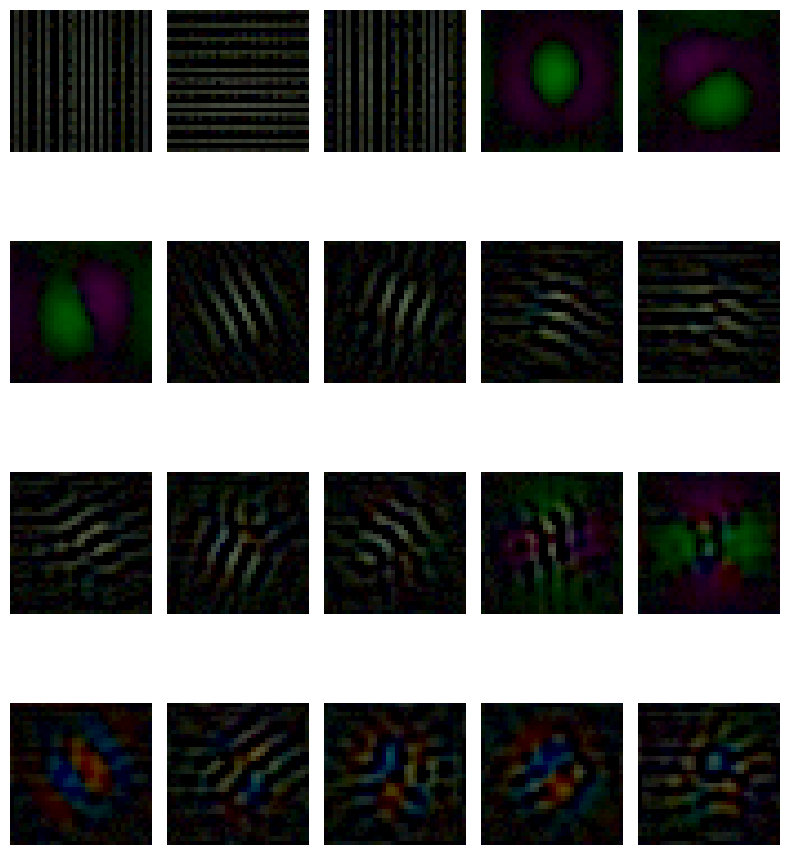

In [23]:
projection = model_torch.conv_proj.weight.detach().numpy()
plot_pca_components(projection)

In [24]:
projection.shape

(768, 3, 32, 32)

# Position Embedding Similarity

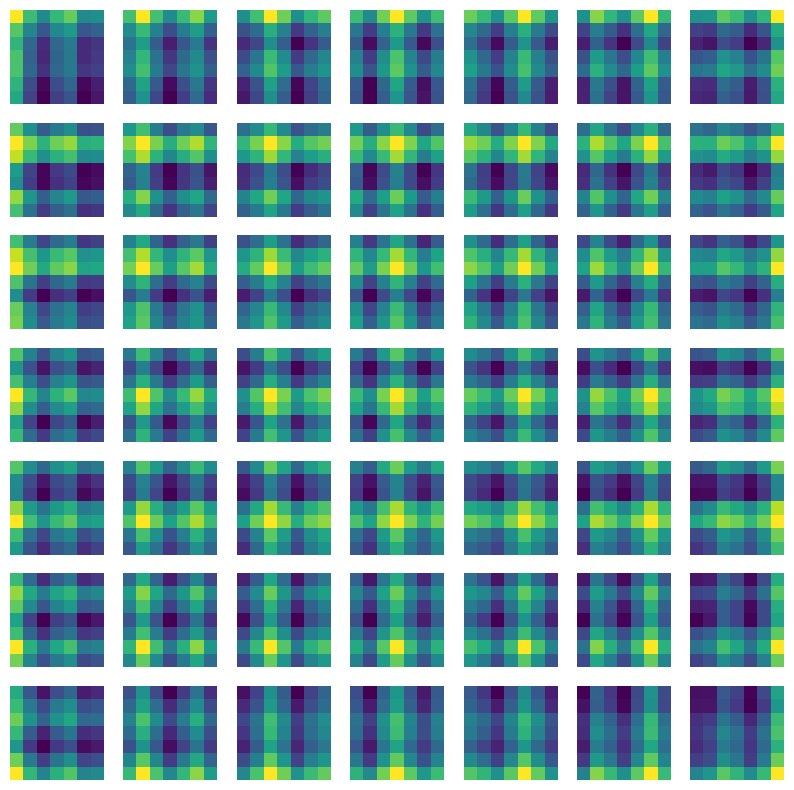

In [26]:
pos_embeddings = model_torch.encoder.pos_embedding[0, 1:, :].detach().numpy() # remove class_token
from sklearn.metrics.pairwise import cosine_similarity

def plot_pos_emb_sim(pos_embeddings):
    sim = cosine_similarity(pos_embeddings)
    n = int(np.sqrt(sim.shape[0]))
    sim_unroll = np.reshape(sim, (n, n, n, n))
    fig, axs = plt.subplots(n, n, figsize=(10, 10))
    for row in range(n):
        for col in range(n):
            axs[row, col].imshow(sim_unroll[row, col, ...])
            axs[row, col].axis('off')
plot_pos_emb_sim(pos_embeddings)

# Attention

In [170]:
import torch
import torch.nn.functional as F
from transformers import ViTFeatureExtractor, ViTForImageClassification
from PIL import Image

# Load the ViT model from torchvision
model = ViTForImageClassification.from_pretrained("facebook/dino-vits8", output_attentions=True)  # You can choose a different variant
model.eval()

feature_extractor = ViTFeatureExtractor.from_pretrained("facebook/dino-vits8")

# Load and preprocess your input image
image = Image.open("../examples/corgi_image.jpg")
image = feature_extractor(images=image, return_tensors="pt")

outputs = model(**image)
attention_maps = outputs.attentions

Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vits8 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [276]:
def plot_attentions(attention_maps, image, patch_size=8, layer_idx=-1):
    attentions = attention_maps[layer_idx]
    n_heads = attentions.shape[1]
    attentions = attentions[0, :, 0, 1:]
    superpixel_size = int(np.sqrt(attentions.shape[-1]))
    print(attentions.shape)
    attentions = attentions.reshape(n_heads, superpixel_size, superpixel_size)
    attentions = F.interpolate(attentions.unsqueeze(
        0), scale_factor=patch_size, mode="nearest")[0].detach().cpu().numpy()
    fig, axs = plt.subplots(3, 3, figsize=(10, 10))
    axs = np.ravel(axs)
    for idx, ax in enumerate(axs):
        if idx < len(attentions):
            ax.imshow(image[0, 0, ...] * attentions[idx, ...])
        ax.axis("off")

torch.Size([6, 784])


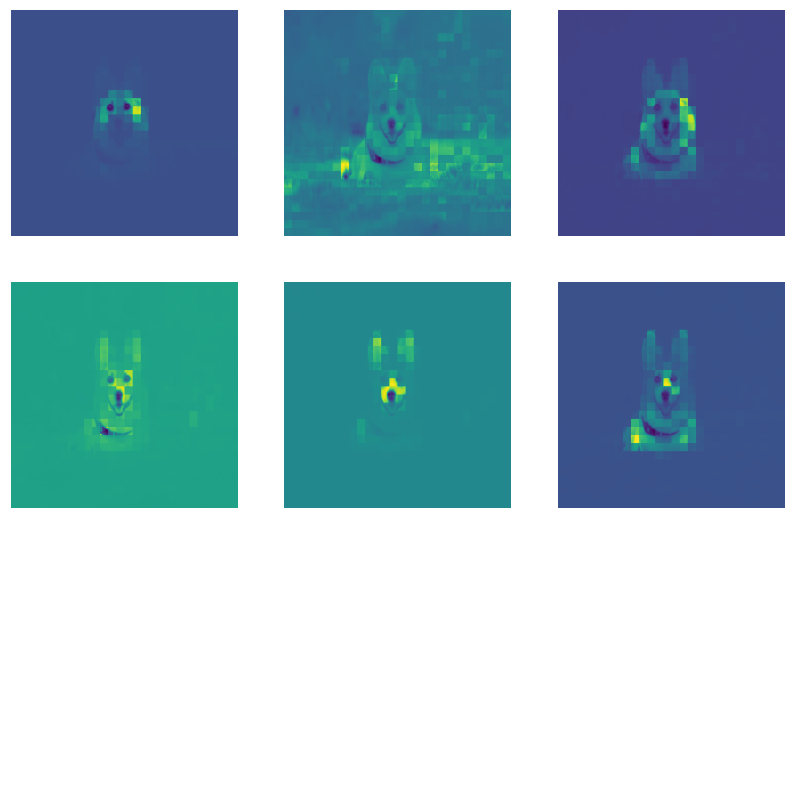

In [277]:
plot_attentions(attention_maps, image["pixel_values"])

In [161]:
# plt.imshow(attention_map.reshape(7, 7))

In [56]:
image["pixel_values"].shape

torch.Size([1, 3, 224, 224])

In [177]:
attention_maps[0].shape

torch.Size([1, 6, 785, 785])